In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import os
import glob
import sys
sys.path.append("../scripts/")
from utils import calculate_mass, CCS_from_K0_inv
import re
from getsequence import getsequence_onefile
from radius_of_gyration import Rg

In [2]:
root_path = os.getenv("DATA_DIR")
data_ch3 = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_aligned_train.pkl"))
data_ch3 = data_ch3[data_ch3["Charge"]==3]

# Daniel fit

In [2]:
%run /fs/pool/pool-cox-data08/Juan/ccs/Data/daniel_helix_spheres/imos_savefile_converter.py

filled_He_sparse_sphere_8.8.txt
filled_He_sparse_sphere_9.9.txt
Ala_sparse_sphere_5.8.txt
He_dens_sphere_9.3.txt
Leu_26.txt
filled_He_sparse_sphere_9.3.txt
Ala_sparse_sphere_6.4.txt
He_sparse_sphere_5.8.txt
pept1_0.85.txt
He_dens_sphere_9.9.txt
filled_He_sparse_sphere_N_10.7.txt
W_26.txt
He_sparse_sphere_5.4.txt
Ala_sparse_sphere_5.5.txt
Ala_26.txt
Leu_10.txt
Ala_9.txt
filled_He_sparse_sphere_N_6.0.txt
Leu_13.txt
W_14.txt
He_sparse_sphere_10.8.txt
He_sparse_sphere_6.3.txt
He_sparse_sphere_8.5.txt
filled_He_sparse_sphere_5.6.txt
He_sparse_sphere_6.0.txt
Leu_38.txt
He_sparse_sphere_6.5.txt
Leu_40.txt
filled_He_sparse_sphere_6.9.txt
filled_He_sparse_sphere_N_8.3.txt
Ala_22.txt
pept1_0.95.txt
He_sparse_sphere_8.8.txt
He_dens_sphere_9.8.txt
W_36.txt
Ala_sparse_sphere_8.8.txt
He_sparse_sphere_8.9.txt
Ala_27.txt
He_sparse_sphere_6.1.txt
filled_He_sparse_sphere_N_5.0.txt
filled_He_sparse_sphere_7.2.txt
He_dens_sphere_7.5.txt
filled_He_sparse_sphere_10.8.txt
Ala_sparse_sphere_7.7.txt
He_sparse_

In [3]:
data = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/daniel_helix_spheres/imos_summary_tmlj.csv")
data["Charge"] = 3

In [4]:
mask = data["name"].str.contains("Ala_|W_|Leu_")
#filter out names containing Ala_sparse_sphere
mask = mask & ~data["name"].str.contains("Ala_sparse_sphere")
df_helices = data[mask]
df_spheres = data[~mask]

In [5]:
# Mapping dictionary
mapping = {
    "Leu": "L",
    "W": "W",
    "Ala": "A"
}

# Function to extract the AtomType and length
def extract_values(name):
    match = re.match(r"(\w+)_(\d+)\.pdb", name)
    if match:
        atom_type = match.group(1)
        length = int(match.group(2))
        # Map the extracted atom type
        mapped_atom_type = str(mapping.get(atom_type, atom_type))  # Default to the same value if not in mapping
        sequence = length*mapped_atom_type
        return sequence
    return None

# Apply the function to the DataFrame
df_helices['Sequence'] = df_helices['name'].apply(extract_values)
df_helices['Mass'] = df_helices['Sequence'].apply(lambda x: calculate_mass(x))
df_helices['m/z'] = df_helices.apply(lambda x: calculate_mass(x['Sequence'], x['Charge']), axis=1)

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [6]:
mass = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/daniel_helix_spheres/mass_for_hollow_dens_He_sphere.dat")
mass.sort_values(by='radius A',inplace=True)

In [7]:
# Function to extract the float number (radius)
def extract_radius(name):
    match = re.search(r"_(\d+\.\d+)\.pdb", name)
    if match:
        return float(match.group(1))
    return None

# Apply the function to create the 'radius' column
df_spheres['radius A'] = df_spheres['name'].apply(extract_radius)

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [8]:
#round floats so the matching is possible
df_spheres['radius A'] = df_spheres['radius A'].round(2)
mass["radius A"] = mass["radius A"].round(2)

df_spheres = pd.merge(df_spheres, mass, on='radius A', how='left')

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
df_spheres['m/z'] = (df_spheres['mass Da']+df_spheres['Charge'])/df_spheres['Charge']

In [10]:
root_path = os.getenv("DATA_DIR")
data_ch3 = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_aligned_train.pkl"))
data_ch3 = data_ch3[data_ch3["Charge"]==3]
data_ch3["Aligned CCS"] = CCS_from_K0_inv(data_ch3["Aligned 1/K0"], data_ch3["Charge"], data_ch3["Mass"])

(350.0, 1500.0)

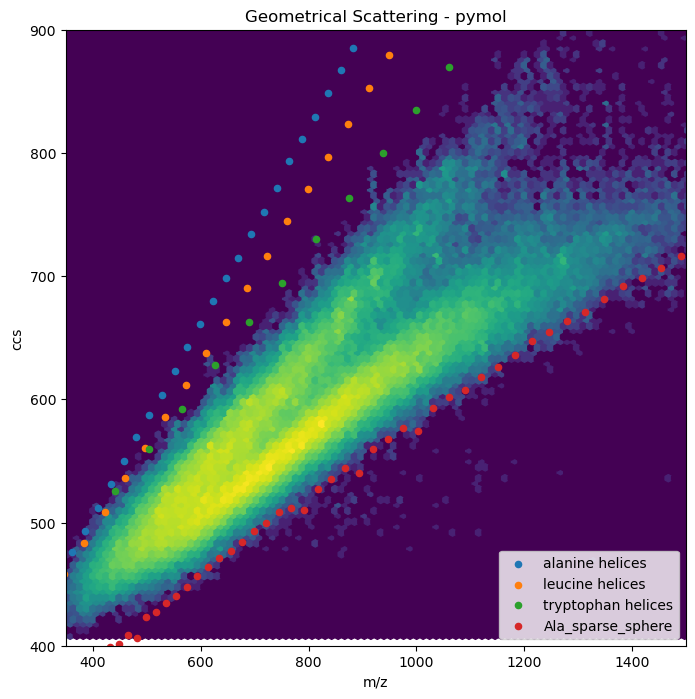

In [13]:
plt.figure(figsize=(8,8))
#hexbin plot
plt.hexbin(data_ch3["m/z"], data_ch3["Aligned CCS"], gridsize=100, bins='log')	
mask_ala = df_helices['name'].str.contains("Ala")
plt.scatter(df_helices.loc[mask_ala,"m/z"], df_helices.loc[mask_ala,"ccs"],s=20, label="alanine helices")
mas_leu = df_helices['name'].str.contains("Leu")
plt.scatter(df_helices.loc[mas_leu,"m/z"], df_helices.loc[mas_leu,"ccs"],s=20, label="leucine helices")
mask_w = df_helices['name'].str.contains("W")
plt.scatter(df_helices.loc[mask_w,"m/z"], df_helices.loc[mask_w,"ccs"],s=20, label="tryptophan helices")
mask_sph_1  = df_spheres['name'].str.contains('Ala_sparse_sphere')
plt.scatter(df_spheres.loc[mask_sph_1,"m/z"], df_spheres.loc[mask_sph_1,"ccs"],s=20, label="Ala_sparse_sphere")
plt.legend()
plt.title("Geometrical Scattering - pymol")
plt.xlabel("m/z")
plt.ylabel("ccs")
plt.ylim(400,900)
plt.xlim(350,1500)

# Tobias fit

#### Metadata

In [4]:
df_exp = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/MaxQuant/evidence_fromRawFiles_unique.csv")

charge = 2
# create Data Frame for IMos
path_pdb = f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/globes/surface_spherical_inner_structure_charge{charge}/"


imos_df = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/imos_summary_globes_{charge}.csv", index_col=False)


imos_df = imos_df.rename(columns={'name': 'Names'})

/fs/home/rlopez/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:

imos_sequences = [getsequence_onefile(path_pdb + str(i),charge) for i in imos_df["Names"]]
imos_df["Sequence"] = imos_sequences

In [6]:

df_exp_filtered = df_exp[df_exp["Sequence"].isin(imos_sequences) & (df_exp["Charge"] == charge) & (df_exp["Modifications"] == "Unmodified")]


missing_in_series1 =  set(imos_df["Sequence"]) - set(df_exp_filtered["Sequence"])


imos_df = imos_df[~imos_df['Sequence'].isin(missing_in_series1)]
imos_df

Names       ccs        k0  NofAtoms         Sequence
0      x035043.pdb  311.9786  544.9972       160       LIELLCGLGK
2      x009081.pdb  332.9346  509.8898       173    DFLAGGVAAAVSK
3      x058138.pdb  328.0779  517.4969       176       LSEIVLHNLR
4      x096793.pdb  352.0922  481.3029       216     TVLTFYLLNVLK
5      x234354.pdb  351.4695  482.3082       189    NYGSLIGEATAER
...            ...       ...       ...       ...              ...
44088  x300156.pdb  363.4869  465.9036       226   KIIKSANDLVETLS
44089  x185093.pdb  329.1712  515.7932       173      EEITAVLAAFK
44090  x242754.pdb  346.7456  488.9977       196    LAIGITANFVNGR
44091  x143546.pdb  334.4894  507.1989       174      ITSIFNEHCGR
44092  x161259.pdb  380.3272  444.8256       250  YVALQFLRNSEIAAK

[43799 rows x 5 columns]

In [7]:
df_exp_filtered = df_exp_filtered.sort_values(by='Sequence', ascending=False)
imos_df = imos_df.sort_values(by='Sequence', ascending=False)
imos_df["m/z"] = df_exp_filtered["m/z"].values
imos_df["mass"] = df_exp_filtered["Mass"].values
imos_df["Rg"] = [Rg(path_pdb + str(i) ) for i in imos_df["Names"]]
imos_df["Rg_to_len_Seq"] = imos_df["Rg"]/len(imos_df["Sequence"])

In [8]:
imos_df.to_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/metadata_globes_charge_{charge}.csv")

### Charge 2

In [2]:
%run /fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_savefile_converter.py 2

Processing charge 2 and structure globes
Processing file: x035043.txt
Processing file: x054895.txt
Processing file: x009081.txt
Processing file: x058138.txt
Processing file: x096793.txt
Processing file: x234354.txt
Processing file: x210158.txt
Processing file: x182263.txt
Processing file: x249159.txt
Processing file: x241190.txt
Processing file: x263908.txt
Processing file: x045638.txt
Processing file: x208562.txt
Processing file: x236451.txt
Processing file: x119040.txt
Processing file: x219205.txt
Processing file: x219645.txt
Processing file: x100740.txt
Processing file: x166356.txt
Processing file: x099412.txt
Processing file: x129041.txt
Processing file: x103356.txt
Processing file: x101050.txt
Processing file: x042355.txt
Processing file: x292768.txt
Processing file: x212036.txt
Processing file: x025805.txt
Processing file: x293400.txt
Processing file: x066208.txt
Processing file: x199536.txt
Processing file: x011392.txt
Processing file: x149841.txt
Processing file: x036276.txt
Pr

In [9]:
charge = 2

In [10]:
globes = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/imos_summary_globes_{charge}.csv")
helices = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/imos_summary_helices_{charge}.csv")

In [11]:
globes.shape, helices.shape

((44093, 4), (44083, 4))

In [12]:
metadata_globes = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/metadata_globes_charge_{charge}.csv")
metadata_helices = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/metadata_helices_charge_{charge}.csv")

In [13]:
metadata_globes.shape, metadata_helices.shape

((43799, 10), (43789, 9))

In [14]:
globes["name"] = globes["name"].apply(lambda x: x[:-4])
helices["name"] = helices["name"].apply(lambda x: x[:-4])
metadata_globes["Names"] = metadata_globes["Names"].apply(lambda x: x[:-4])
metadata_helices["Names"] = metadata_helices["Names"].apply(lambda x: x[:-4])

In [15]:
#merge imos_srgace and metadata on name and Names
globes = pd.merge(globes, metadata_globes[["Names", "Sequence", "m/z"]], left_on='name', right_on='Names', how='inner')
helices = pd.merge(helices, metadata_helices[["Names", "Sequence", "m/z"]], left_on='name', right_on='Names', how='inner')

In [16]:
globes.shape, helices.shape

((43799, 7), (43789, 7))

In [17]:
# Define the power law function
#THIS IS MASS AND NOT MASS TO CHARGE
#globes = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/surface_inner_peptide.csv")
def power_law(x, a, b):
    return a * np.power(x, b)

globes["mass"] = globes["m/z"]*charge - charge
# Perform the curve fitting
params, covariance = curve_fit(power_law, globes["mass"], globes["ccs"])

# Extract the fitting parameters
a_fit, b_fit = params
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")

# Generate y-values based on the fitted parameters
y_fit = power_law(globes["mass"], a_fit, b_fit)

# Calculate R^2 value
residuals = globes["ccs"] - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((globes["ccs"] - np.mean(globes["ccs"]))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2: {r_squared}")

Fitted parameters: a = 16.281794928933277, b = 0.42399869926313316
R^2: 0.9867577695162822


In [18]:
# Perform linear regression using numpy.polyfit
#helices = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/alpha_helix_peptide.csv")

helices["mass"] = helices["m/z"]*charge - charge
slope, intercept = np.polyfit(helices["mass"], helices["ccs"], 1)

# Print the slope and intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

# Calculate the fitted values
y_fitted = slope * helices["mass"] + intercept

Slope: 0.2349308265108533
Intercept: 198.32155627664514


In [22]:
root_path = os.getenv("DATA_DIR")
data_ch2 = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_aligned_train_v2660.pkl"))


In [23]:
data_ch2 = data_ch2[data_ch2["Charge"]==2]
data_ch2["Aligned CCS"] = CCS_from_K0_inv(data_ch2["Aligned 1/K0"], data_ch2["Charge"], data_ch2["Mass"])

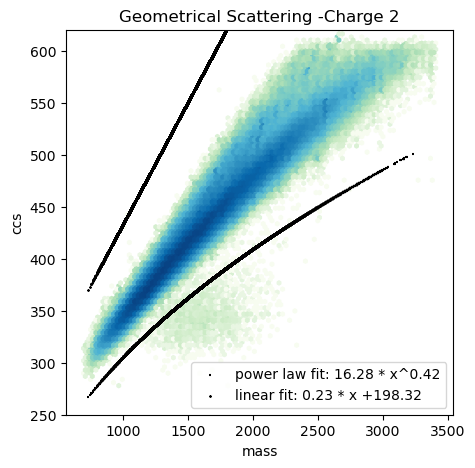

In [26]:
#plt.scatter(df_surface["m/z"], df_surface["ccs"], label='fib. spheres',s=4)
plt.figure(figsize=(5,5))
plt.hexbin(data_ch2["Mass"], data_ch2["Aligned CCS"], gridsize=100, bins='log', mincnt=1, cmap="GnBu")
plt.scatter(globes["mass"], y_fit, color='black', label=f'power law fit: {a_fit:.2f} * x^{b_fit:.2f}', marker= "_",s=1)
#point cloud
plt.scatter(helices["mass"], y_fitted, color='black', label=f'linear fit: {slope:.2f} * x +{intercept:.2f}', marker= "*",s=1)
#point cloud
plt.title(f"Geometrical Scattering -Charge {charge}")
plt.xlabel("mass")
plt.ylabel("ccs")
plt.ylim(250,620)
plt.legend()

### Charge 3

In [9]:
%run /fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_savefile_converter.py 3

x050772.txt
x083504.txt
x089725.txt
x003201.txt
x067457.txt
x034448.txt
x060048.txt
x037320.txt
x010902.txt
x057094.txt
x086658.txt
x094049.txt
x096566.txt
x044755.txt
x019440.txt
x062954.txt
x003986.txt
x089464.txt
x038150.txt
x084884.txt
x051609.txt
x033511.txt
x017054.txt
x104089.txt
x109383.txt
x013797.txt
x056080.txt
x035817.txt
x044327.txt
x111180.txt
x077159.txt
x027006.txt
x108282.txt
x081506.txt
x101428.txt
x084093.txt
x025157.txt
x019096.txt
x057132.txt
x050314.txt
x015702.txt
x102569.txt
x050364.txt
x046150.txt
x011405.txt
x096326.txt
x095280.txt
x042196.txt
x082813.txt
x097465.txt
x083639.txt
x001286.txt
x016997.txt
x102201.txt
x012962.txt
x017741.txt
x012375.txt
x015941.txt
x036747.txt
x000047.txt
x109131.txt
x066311.txt
x041372.txt
x081114.txt
x065146.txt
x065724.txt
x099650.txt
x036064.txt
x051708.txt
x022082.txt
x076522.txt
x028213.txt
x032765.txt
x082934.txt
x021671.txt
x059345.txt
x030240.txt
x014913.txt
x046834.txt
x094833.txt
x049206.txt
x011968.txt
x055968.txt
x107

In [14]:
imos_surface = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_summary_tmlj.csv")

In [15]:
metadata = pd.read_csv("/fs/pool/pool-cox-projects-fold/curvefitting_helix_spherical/spherical_inner_peptides/surface_inner_peptide.csv")

In [16]:
imos_surface["name"] = imos_surface["name"].apply(lambda x: x[:-4])

In [17]:
#merge imos_srgace and metadata on name and Names
df_surface = pd.merge(imos_surface, metadata[["Names", "Sequence", "m/z"]], left_on='name', right_on='Names', how='inner')

In [18]:
df_alpha = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/alpha_helix_peptide.csv")
#df_surface = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/surface_inner_peptide.csv")

In [19]:
df_alpha["length"] = [len(i) for i in df_alpha["Sequence"]]
df_surface["length"] = [len(i) for i in df_surface["Sequence"]]

In [20]:
# Define the power law function
#THIS IS MASS AND NOT MASS TO CHARGE
#df_surface = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/surface_inner_peptide.csv")
def power_law(x, a, b):
    return a * np.power(x, b)

df_surface["mass"] = df_surface["m/z"]*3 - 3
# Perform the curve fitting
params, covariance = curve_fit(power_law, df_surface["mass"], df_surface["ccs"])

# Extract the fitting parameters
a_fit, b_fit = params
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")

# Generate y-values based on the fitted parameters
y_fit = power_law(df_surface["mass"], a_fit, b_fit)

# Calculate R^2 value
residuals = df_surface["ccs"] - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((df_surface["ccs"] - np.mean(df_surface["ccs"]))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2: {r_squared}")

Fitted parameters: a = 20.494462480115118, b = 0.41490623750446703
R^2: 0.9866485379598556


In [21]:
# Perform linear regression using numpy.polyfit
#df_alpha = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/alpha_helix_peptide.csv")

df_alpha["mass"] = df_alpha["m/z"]*3 - 3
slope, intercept = np.polyfit(df_alpha["mass"], df_alpha["ccs"], 1)

# Print the slope and intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

# Calculate the fitted values
y_fitted = slope * df_alpha["mass"] + intercept

Slope: 0.23213348498223593
Intercept: 240.91071404535916


In [22]:
root_path = os.getenv("DATA_DIR")
data_ch3 = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_aligned_train.pkl"))
data_ch3 = data_ch3[data_ch3["Charge"]==3]
data_ch3["Aligned CCS"] = CCS_from_K0_inv(data_ch3["Aligned 1/K0"], data_ch3["Charge"], data_ch3["Mass"])

In [23]:
plt.style.use('science')

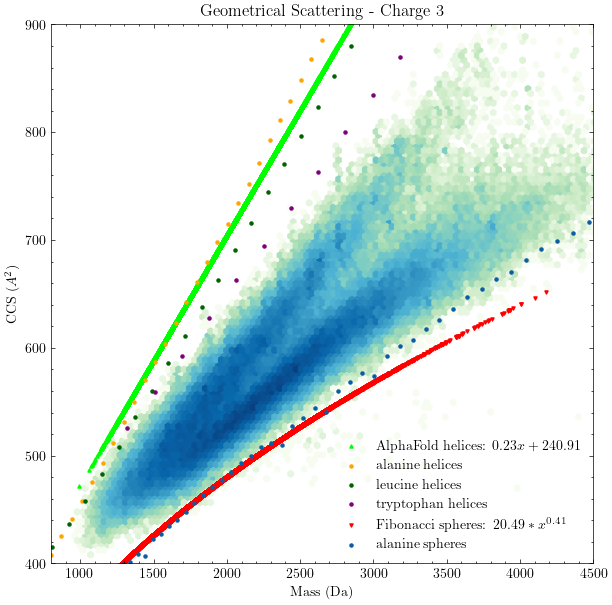

In [55]:
#plt.scatter(df_surface["m/z"], df_surface["ccs"], label='fib. spheres',s=4)
plt.figure(figsize=(7,7))
plt.hexbin(data_ch3["Mass"], data_ch3["Aligned CCS"], gridsize=100, bins='log', cmap="GnBu", mincnt=1)

#helices
plt.scatter(df_alpha["mass"], y_fitted, color='lime', label=f'AlphaFold helices: ${{{slope:.2f}}} x +{{{intercept:.2f}}}$',s=5, marker='^')
mask_ala = df_helices['name'].str.contains("Ala")
plt.scatter(df_helices.loc[mask_ala,"Mass"], df_helices.loc[mask_ala,"ccs"],s=5, label="alanine helices", color='orange')
mas_leu = df_helices['name'].str.contains("Leu")
plt.scatter(df_helices.loc[mas_leu,"Mass"], df_helices.loc[mas_leu,"ccs"],s=5, label="leucine helices", color='darkgreen')
mask_w = df_helices['name'].str.contains("W")
plt.scatter(df_helices.loc[mask_w,"Mass"], df_helices.loc[mask_w,"ccs"],s=5, label="tryptophan helices", color='purple')
#spheres
plt.scatter(df_surface["mass"], y_fit, color='red', label=f'Fibonacci spheres: ${{{a_fit:.2f}}} * x^{{{b_fit:.2f}}}$', s=5, marker='v')
mask_sph_1  = df_spheres['name'].str.contains('Ala_sparse_sphere')
plt.scatter(df_spheres.loc[mask_sph_1,"mass Da"], df_spheres.loc[mask_sph_1,"ccs"],s=5, label="alanine spheres")

#point cloud
plt.title("Geometrical Scattering - Charge 3")
plt.xlabel("Mass (Da)")
plt.ylabel("CCS $(A^2)$")
plt.ylim(400,900)
plt.xlim(800, 4500)
plt.legend(loc="lower right")

### Charge 4

In [57]:
charge = 4

In [58]:
globes = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/imos_summary_globes_{charge}.csv")
helices = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/imos_summary_helices_{charge}.csv")

In [59]:
metadata_globes = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/metadata_globes_charge_{charge}.csv")
metadata_helices = pd.read_csv(f"/fs/pool/pool-cox-data08/Juan/ccs/Data/tobias_helix_spheres/imos_results/metadata_helices_charge_{charge}.csv")

In [60]:
globes["name"] = globes["name"].apply(lambda x: x[:-4])
helices["name"] = helices["name"].apply(lambda x: x[:-4])
metadata_globes["Names"] = metadata_globes["Names"].apply(lambda x: x[:-4])
metadata_helices["Names"] = metadata_helices["Names"].apply(lambda x: x[:-4])

In [61]:
#merge imos_srgace and metadata on name and Names
globes = pd.merge(globes, metadata_globes[["Names", "Sequence", "m/z"]], left_on='name', right_on='Names', how='inner')
helices = pd.merge(helices, metadata_helices[["Names", "Sequence", "m/z"]], left_on='name', right_on='Names', how='inner')

In [62]:
# Define the power law function
#THIS IS MASS AND NOT MASS TO CHARGE
#globes = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/surface_inner_peptide.csv")
def power_law(x, a, b):
    return a * np.power(x, b)

globes["mass"] = globes["m/z"]*charge - charge
# Perform the curve fitting
params, covariance = curve_fit(power_law, globes["mass"], globes["ccs"])

# Extract the fitting parameters
a_fit, b_fit = params
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")

# Generate y-values based on the fitted parameters
y_fit = power_law(globes["mass"], a_fit, b_fit)

# Calculate R^2 value
residuals = globes["ccs"] - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((globes["ccs"] - np.mean(globes["ccs"]))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R^2: {r_squared}")

Fitted parameters: a = 24.545962307741394, b = 0.4057952293138653
R^2: 0.9880938966560701


In [63]:
# Perform linear regression using numpy.polyfit
#helices = pd.read_csv("/fs/pool/pool-cox-data08/Juan/ccs/Data/geometrical_fit/alpha_helix_peptide.csv")

helices["mass"] = helices["m/z"]*charge - charge
slope, intercept = np.polyfit(helices["mass"], helices["ccs"], 1)

# Print the slope and intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

# Calculate the fitted values
y_fitted = slope * helices["mass"] + intercept

Slope: 0.23044395967098313
Intercept: 290.0768958784547


In [64]:
root_path = os.getenv("DATA_DIR")
data_ch4 = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_aligned_train.pkl"))

In [65]:
data_ch4 = data_ch4[data_ch4["Charge"]==charge]
data_ch4["Aligned CCS"] = CCS_from_K0_inv(data_ch4["Aligned 1/K0"], data_ch4["Charge"], data_ch4["Mass"])

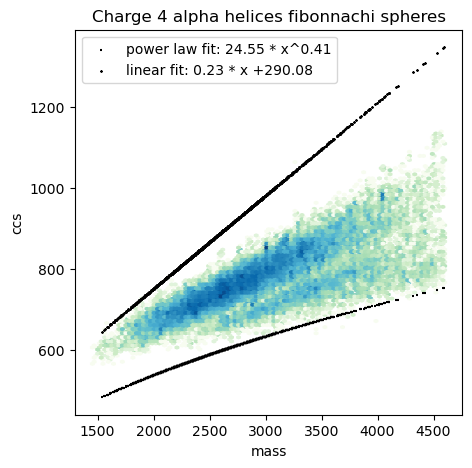

In [67]:
#plt.scatter(df_surface["m/z"], df_surface["ccs"], label='fib. spheres',s=4)
plt.figure(figsize=(5,5))
plt.hexbin(data_ch4["Mass"], data_ch4["Aligned CCS"], gridsize=100, bins='log', mincnt=1,  cmap="GnBu")
plt.scatter(globes["mass"], y_fit, color='black', label=f'power law fit: {a_fit:.2f} * x^{b_fit:.2f}', marker= "_",s=1)
#point cloud
plt.scatter(helices["mass"], y_fitted, color='black', label=f'linear fit: {slope:.2f} * x +{intercept:.2f}', marker= "*",s=1)
#point cloud
plt.title(f"Charge {charge} alpha helices fibonnachi spheres")
plt.xlabel("mass")
plt.ylabel("ccs")
plt.legend()